<a href="https://colab.research.google.com/github/denk08n88/Redes-Neuronales/blob/main/Indian_Food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas y utilidades

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json, matplotlib
#s = json.load( open("styles/bmh_matplotlibrc.json") )
#matplotlib.rcParams.update(s)
from IPython.core.pylabtools import figsize
figsize(11, 5)
colores = ["#348ABD", "#A60628","#06A628"]

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
#Definimos el dispositivo que se usará.
device = torch.device('cpu')

In [3]:
import pandas as pd
import numpy as np
import re
from time import time

In [4]:
## del archivo utils.py

def indice_division(tensor,fracc):
    # fraccion para prueba y validacion
    cutting_index = int(tensor.size(0)*fracc)
    return cutting_index

def dividir_dataset(tensor,cut_index,axis=1):
    # division del dataset, prueba
    if axis == 1:
        data_1 = tensor[:cut_index,:].float()
        data_2 = tensor[cut_index:,:].float()
    elif axis == 0:
        data_1 = tensor[:,:cut_index].float()
        data_2 = tensor[:,cut_index:].float()

    return data_1, data_2

def only_max(out):
    '''Deja como 1 la salida de la neurona con mayor activacion, las demás en 0
    '''
    import torch
    indices = []
    for row in out:
        row_enum = [(i,j.item()) for i,j in enumerate(row)]
        indices.append(max(row_enum, key = lambda x: x[1])[0])

    indices = torch.tensor(indices)
    indices = indices.reshape(indices.size(0),1)

    one_hot = torch.zeros(*out.shape)
    for i,pos in enumerate(indices):
        one_hot[i,pos] = 1

    return indices, one_hot
            

def confusion(model, X, Y_ohe):
    '''Define una función de confusión con la que puedas comparar el resultado entre la red 
    que se entreno usando backpropagation y la red con mejor fitness resultante del algoritmo genético.
    '''

    H = model.forward(X)
    _,H_ohe = only_max(H)
    
    TP, FP, FN, TN = 0,0,0,0
    for h,y in zip(H_ohe.numpy().ravel(),Y_ohe.numpy().ravel()):
        if h == y:
            if y: 
                TP += 1
            else: 
                TN += 1
        else:   
            if y: 
                FN += 1
            else: 
                FP += 1
  
    matriz_de_confusion = np.array([[TP,FP],[FN,TN]])
    etiquetas_mdc = np.array([['TP','FP'],['FN','TN']])

    eje_x = ['Predicción Positiva','Predicción Negativa']
    eje_y = ['Valor real Positivo','Valor real Negativo']

    fig, ax = plt.subplots()
    im = ax.imshow(matriz_de_confusion)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(eje_x)))
    ax.set_yticks(np.arange(len(eje_y)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(eje_x)
    ax.set_yticklabels(eje_y)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, etiquetas_mdc[j,i] + ':\n' + str(matriz_de_confusion[i, j]),
                ha="center", va="center", color="w")

    # Colorbar 
    cbar = ax.figure.colorbar(im, ax=ax)
    #cbar.ax.set_ylabel('', rotation=-90, va="bottom")

    ax.set_title("Matriz de confusión")
    fig.tight_layout()
    plt.show()


def get_accuracy(model,X,Y):
    print(Y)
    totales = Y.size(0)
    H = model.forward(X)
    Y_,_ = only_max(Y) 
    H,_ = only_max(H)
    acertados = sum([h==y for h,y in zip(H,Y_)]).item()
    accuracy = acertados/totales 
    return accuracy


In [5]:
# Generador aleatorio
rng = np.random.default_rng()

# Importamos el dataset

In [6]:
path = './indian_food.csv'
df = pd.read_csv('./indian_food.csv', na_values='-1' )
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
0,Sukhdi,"Whole wheat flour, gur, clarified butter",vegetarian,10.0,20.0,sweet,dessert,Maharashtra,West
1,Vindaloo,"Chicken, coconut oil, wine vinegar, ginger, gr...",non vegetarian,10.0,40.0,spicy,main course,Goa,West
2,Pani Pitha,"Tea leaves, white sesame seeds, dry coconut, s...",vegetarian,10.0,20.0,NaN,main course,Assam,North East
3,Pakhala,"Curd, cooked rice, curry leaves, dry chilli",vegetarian,NaN,NaN,NaN,main course,Odisha,East
4,Vegetable jalfrezi,"Baby corn, french beans, garam masala, ginger,...",vegetarian,10.0,30.0,spicy,main course,Punjab,North
5,Kadhi pakoda,"Besan, garam masala powder, gram flour, ginger...",vegetarian,10.0,60.0,spicy,main course,Haryana,North
6,Bombil fry,"Bombay duck, malvani masala, rice flour, bomba...",non vegetarian,NaN,NaN,spicy,main course,Maharashtra,West
7,Palak paneer,"Cottage cheese, palak, cream, garam masala, bu...",vegetarian,20.0,40.0,spicy,main course,Punjab,North
8,Sev khamani,"Khaman, pomegranate, sev, powdered sugar, garlic",vegetarian,20.0,30.0,spicy,main course,Gujarat,West
9,Chak Hao Kheer,"Rice, milk, sugar, cardamom",vegetarian,240.0,45.0,sweet,dessert,Manipur,North East


### Limpieza de datos en el dataframe

In [7]:
# Para eliminar los nan:
# Opcion 1:
# df[df.isnull().any(axis=1)] ## faltaria un paso
# Opcion 2:
# DataFrame.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
# axis: {0 or ‘index’, 1 or ‘columns’}, default 0
df.dropna(inplace = True)

In [8]:
# Exploramos los tipos de datos en el dataframe
df.dtypes

name               object
ingredients        object
diet               object
prep_time         float64
cook_time         float64
flavor_profile     object
course             object
state              object
region             object
dtype: object

# Preprocesamiento de los datos

In [9]:
# Para seleccionar un tipo especifico de variable
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head(10)

,name,ingredients,diet,flavor_profile,course,state,region
0,Sukhdi,"Whole wheat flour, gur, clarified butter",vegetarian,sweet,dessert,Maharashtra,West
1,Vindaloo,"Chicken, coconut oil, wine vinegar, ginger, gr...",non vegetarian,spicy,main course,Goa,West
4,Vegetable jalfrezi,"Baby corn, french beans, garam masala, ginger,...",vegetarian,spicy,main course,Punjab,North
5,Kadhi pakoda,"Besan, garam masala powder, gram flour, ginger...",vegetarian,spicy,main course,Haryana,North
7,Palak paneer,"Cottage cheese, palak, cream, garam masala, bu...",vegetarian,spicy,main course,Punjab,North
8,Sev khamani,"Khaman, pomegranate, sev, powdered sugar, garlic",vegetarian,spicy,main course,Gujarat,West
9,Chak Hao Kheer,"Rice, milk, sugar, cardamom",vegetarian,sweet,dessert,Manipur,North East
10,Namakpara,"Wheat flour, baking soda, all purpose flour, b...",vegetarian,spicy,snack,Gujarat,West
11,Churma Ladoo,"Whole wheat flour, khus khus, sesame seeds, dr...",vegetarian,sweet,dessert,Rajasthan,West
12,Lassi,"Yogurt, milk, nuts, sugar",vegetarian,sweet,dessert,Punjab,North


In [10]:
# De la siguiente forma podemos ver cuantos elementos hay de cada categoria en las 
# variables categoricas:
obj_columns = obj_df.columns
# Usamos el método drop de Index, pues obj_columns ahora es un Index
# https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.Index.drop.html
obj_columns = obj_columns.drop(['name','ingredients'])
for column in obj_columns:
    print(f"\033[1m{column}\033[0m")
    print(f"{df[column].value_counts()}\n")

diet
vegetarian        163
non vegetarian     17
Name: diet, dtype: int64

flavor_profile
spicy     102
sweet      73
bitter      4
sour        1
Name: flavor_profile, dtype: int64

course
main course    83
dessert        70
snack          25
starter         2
Name: course, dtype: int64

state
Punjab             30
Gujarat            29
Maharashtra        23
West Bengal        20
Tamil Nadu         13
Andhra Pradesh     10
Assam               8
Uttar Pradesh       8
Rajasthan           6
Odisha              5
Karnataka           5
Telangana           5
Kerala              4
Bihar               3
Madhya Pradesh      2
Goa                 2
NCT of Delhi        1
Manipur             1
Haryana             1
Nagaland            1
Uttarakhand         1
Chhattisgarh        1
Jammu & Kashmir     1
Name: state, dtype: int64

region
West          60
North         45
South         37
East          25
North East    10
Central        3
Name: region, dtype: int64



In [11]:
# La columna de nombres no la usaremos, así que la quitamos y la guardamos
if 'name' in df.columns:
    names = df.pop('name')

In [12]:
# Quitamos y guardamos la columna de ingredientes, ya que a esta columna le daremos un tratamiento distinto
if 'ingredients' in df.columns:
    ingredients = df.pop('ingredients')

In [13]:
# Aplicaremos un label encoding a las columnas categoricas
df[obj_columns] = df[obj_columns].astype('category')
df.dtypes

diet              category
prep_time          float64
cook_time          float64
flavor_profile    category
course            category
state             category
region            category
dtype: object

In [14]:
# Ahora, modificamos estas columnas con su respectivo label enconding
# Primero, creamos un diccionario para que nos sea facil movernos entre el codigo y el nombre real
code_cat_dict = {col: dict(enumerate(df[col].cat.categories)) for col in obj_columns}
for col in obj_columns:
    if df[col].dtype.name == 'category': # dtype.name #
        df[col] = df[col].cat.codes
    else:
        print(f"{col:<20}{df[col].dtype}")
df.head()

,diet,prep_time,cook_time,flavor_profile,course,state,region
0,1,10.0,20.0,3,0,11,5
1,0,10.0,40.0,2,1,4,5
4,1,10.0,30.0,2,1,16,2
5,1,10.0,60.0,2,1,6,2
7,1,20.0,40.0,2,1,16,2


In [15]:
# Para leer las categorias de una columna segun su codigo
df['flavor_profile'].map(code_cat_dict['flavor_profile']).astype('category')

0      sweet
1      spicy
4      spicy
5      spicy
7      spicy
       ...  
249    spicy
250    spicy
251    spicy
252    sweet
253    sweet
Name: flavor_profile, Length: 180, dtype: category
Categories (4, object): ['bitter', 'sour', 'spicy', 'sweet']

In [16]:
# Normalizaremos las columnas prep_time y cook_time
# PERO ---  Me fijo en que prep_time y cook_time parece tener valores 'redondos'
# Entonces exploro todas sus 'categorias'
for column in ('prep_time','cook_time'):
    print(f"\033[1m{column}\033[0m")
    print(f"{df[column].value_counts()}\n")

prep_time
10.0     78
20.0     35
15.0     15
5.0      14
30.0     10
25.0      5
240.0     4
45.0      4
120.0     3
40.0      2
180.0     2
35.0      1
480.0     1
150.0     1
500.0     1
12.0      1
60.0      1
70.0      1
80.0      1
Name: prep_time, dtype: int64

cook_time
30.0     49
20.0     27
40.0     23
60.0     19
45.0     13
50.0     10
25.0      8
35.0      8
10.0      6
15.0      5
90.0      3
120.0     3
5.0       2
720.0     1
75.0      1
55.0      1
6.0       1
Name: cook_time, dtype: int64



In [17]:
# Decido normalizarlos
cols = ['prep_time','cook_time']
mean = df[cols].mean()
std = df[cols].std()
df[cols] = (df[cols] - mean)/std
df.head()

,diet,prep_time,cook_time,flavor_profile,course,state,region
0,1,-0.322727,-0.374544,3,0,11,5
1,0,-0.322727,-0.006743,2,1,4,5
4,1,-0.322727,-0.190644,2,1,16,2
5,1,-0.322727,0.361058,2,1,6,2
7,1,-0.166862,-0.006743,2,1,16,2


In [18]:
# Como nuestro target sera la columna state, la colocamos hasta el final
colnames = list(df.columns)
colnames[-1], colnames[-2] = colnames[-2], colnames[-1]
df = df[colnames]
df.head()

,diet,prep_time,cook_time,flavor_profile,course,region,state
0,1,-0.322727,-0.374544,3,0,5,11
1,0,-0.322727,-0.006743,2,1,5,4
4,1,-0.322727,-0.190644,2,1,2,16
5,1,-0.322727,0.361058,2,1,2,6
7,1,-0.166862,-0.006743,2,1,2,16


In [19]:
df.dtypes

diet                 int8
prep_time         float64
cook_time         float64
flavor_profile       int8
course               int8
region               int8
state                int8
dtype: object

In [20]:
# Ahora, aplicamos one hot encoding a las variables 'categoricas' ..(#kwarg prefix#) para 'cambiar' el prefijo de las columnas de ohe
df_ohe = pd.get_dummies(df, columns = obj_columns)
df_ohe.head()

,prep_time,cook_time,diet_0,diet_1,flavor_profile_0,flavor_profile_1,flavor_profile_2,flavor_profile_3,course_0,course_1,course_2,course_3,state_0,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,state_10,state_11,state_12,state_13,state_14,state_15,state_16,state_17,state_18,state_19,state_20,state_21,state_22,region_0,region_1,region_2,region_3,region_4,region_5
0,-0.322727,-0.374544,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,-0.322727,-0.006743,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,-0.322727,-0.190644,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
5,-0.322727,0.361058,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,-0.166862,-0.006743,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [21]:
## Nota: Pude aplicar el ohe sin antes pasar a códigos numéricos las categorias. Una ventaja de hacerlo como lo  hice,
## es que los nombres de las columnas del ohe son: prefijo_numero. De la otra forma serian: prefijo_nombre_de_la_categoria

In [22]:
# Guardamos el orden de las columnas para reconocer cada variable
columns_order_to_tensor = df_ohe.columns

##### Preprocesamiento de la columna 'ingrendients'

In [23]:
ingredients.head(10)

0              Whole wheat flour, gur, clarified butter
1     Chicken, coconut oil, wine vinegar, ginger, gr...
4     Baby corn, french beans, garam masala, ginger,...
5     Besan, garam masala powder, gram flour, ginger...
7     Cottage cheese, palak, cream, garam masala, bu...
8      Khaman, pomegranate, sev, powdered sugar, garlic
9                           Rice, milk, sugar, cardamom
10    Wheat flour, baking soda, all purpose flour, b...
11    Whole wheat flour, khus khus, sesame seeds, dr...
12                            Yogurt, milk, nuts, sugar
Name: ingredients, dtype: object

In [24]:
# Convertimos cada entrada del dataframe, obteniendo listas de los ingredientes
ingredients = ingredients.apply(lambda x: x.lower().split(', '))

In [56]:
duplicates = flatten(ingredients.tolist())
ingredients_count = {k:duplicates.count(k) for k in all_ingredients}
print(ingredients_count)

{'star anise': 2, 'dinner rolls': 1, 'spices': 1, 'sev': 2, 'arhar dal': 3, 'lamb': 1, 'red kidney beans': 1, 'kewra': 1, 'tindora': 1, 'coconut milk': 3, 'tea bags': 1, 'dry fruits': 3, 'rava': 6, 'fish fillets': 1, 'masoor dal': 1, 'semolina': 6, 'green chilies': 4, 'cashews': 3, 'kala jeera': 1, 'pearl onions': 1, 'maida': 2, 'carrot': 2, 'urad dal': 13, 'beef': 1, 'fresh green chilli': 1, 'toor dal': 1, 'red chilli': 2, 'ridge gourd': 3, 'khus-khus seeds': 1, 'cabbage': 2, 'split pigeon peas': 1, 'rice': 6, 'tamarind': 1, 'bell pepper': 1, 'green chili': 3, 'jaggery syrup': 1, 'lemon': 2, 'green cardamom': 1, 'heavy cream': 1, 'cardamom powder': 1, 'red chili': 1, 'chicken chunks': 1, 'flour': 4, 'elephant foot yam': 1, 'chicken thighs': 1, 'sorghum flour': 1, 'sooji': 1, 'badam': 1, 'jowar flour': 1, 'nuts': 5, 'hot water': 3, 'beans': 2, 'bottle gourd': 4, 'sliced almonds': 1, 'raw rice': 3, 'raw peanuts': 1, 'canned coconut milk': 1, 'black sesame seeds': 1, 'white urad dal': 1,

In [25]:
flatten = lambda list_: [item for sublist in list_ for item in sublist]
all_ingredients = flatten(ingredients.tolist())
all_ingredients = set(all_ingredients) # remover duplicados
ingredients_dict = {k:v for v,k in enumerate(all_ingredients)}
print(f"Tenemos {len(ingredients_dict)} ingredientes distintos.\n{ingredients_dict}")

Tenemos 286 ingredientes distintos.
{'star anise': 0, 'dinner rolls': 1, 'spices': 2, 'sev': 3, 'arhar dal': 4, 'lamb': 5, 'red kidney beans': 6, 'kewra': 7, 'tindora': 8, 'coconut milk': 9, 'tea bags': 10, 'dry fruits': 11, 'rava': 12, 'fish fillets': 13, 'masoor dal': 14, 'semolina': 15, 'green chilies': 16, 'cashews': 17, 'kala jeera': 18, 'pearl onions': 19, 'maida': 20, 'carrot': 21, 'urad dal': 22, 'beef': 23, 'fresh green chilli': 24, 'toor dal': 25, 'red chilli': 26, 'ridge gourd': 27, 'khus-khus seeds': 28, 'cabbage': 29, 'split pigeon peas': 30, 'rice': 31, 'tamarind': 32, 'bell pepper': 33, 'green chili': 34, 'jaggery syrup': 35, 'lemon': 36, 'green cardamom': 37, 'heavy cream': 38, 'cardamom powder': 39, 'red chili': 40, 'chicken chunks': 41, 'flour': 42, 'elephant foot yam': 43, 'chicken thighs': 44, 'sorghum flour': 45, 'sooji': 46, 'badam': 47, 'jowar flour': 48, 'nuts': 49, 'hot water': 50, 'beans': 51, 'bottle gourd': 52, 'sliced almonds': 53, 'raw rice': 54, 'raw pean

In [26]:
# Creamos un array con la expresión en OHE de cada lista de ingredientes y lo pasamos a un dataframe
ingredients_ohe = ingredients.apply(lambda a: [*map(ingredients_dict.get,a)]) #aplicamos ingredients_dict

In [27]:
ingredients_ohe.head()

0                   [162, 100, 138]
1    [230, 120, 101, 202, 117, 139]
4            [72, 59, 209, 202, 21]
5           [249, 63, 199, 202, 73]
7          [178, 183, 103, 209, 95]
Name: ingredients, dtype: object

In [28]:
def ohe(a,output_size):
    output = [0]*output_size
    for i in a:
        output[int(i)] = 1
    return output

len_dict = len(ingredients_dict)
ingredients_ohe = ingredients_ohe.apply(lambda a: ohe(a,len_dict))
ingredients_ohe = pd.DataFrame(np.array(ingredients_ohe.values.tolist()), index = df.index, columns=[f"ing_{i}" for i in range(len_dict)])
ingredients_ohe.head()

,ing_0,ing_1,ing_2,ing_3,ing_4,ing_5,ing_6,ing_7,ing_8,ing_9,ing_10,ing_11,ing_12,ing_13,ing_14,ing_15,ing_16,ing_17,ing_18,ing_19,ing_20,ing_21,ing_22,ing_23,ing_24,ing_25,ing_26,ing_27,ing_28,ing_29,ing_30,ing_31,ing_32,ing_33,ing_34,ing_35,ing_36,ing_37,ing_38,ing_39,...,ing_246,ing_247,ing_248,ing_249,ing_250,ing_251,ing_252,ing_253,ing_254,ing_255,ing_256,ing_257,ing_258,ing_259,ing_260,ing_261,ing_262,ing_263,ing_264,ing_265,ing_266,ing_267,ing_268,ing_269,ing_270,ing_271,ing_272,ing_273,ing_274,ing_275,ing_276,ing_277,ing_278,ing_279,ing_280,ing_281,ing_282,ing_283,ing_284,ing_285
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# Añadimos este dataframe al df
df_ohe = pd.concat([df_ohe,ingredients_ohe],axis=1)
# Reacomodamos las filas de manera aleatoria
#df_ohe = df_ohe.sample(frac=1)
# Separamos las columnass state, ya que estas conformaran los valores objetivo
targets = df_ohe[[f"state_{i}" for i in range(23)]]
df_ohe.drop([f"state_{i}" for i in range(23)],axis = 1,inplace=True)
# Guardamos el nombre y orden de las columnas
df_ohe.head()

,prep_time,cook_time,diet_0,diet_1,flavor_profile_0,flavor_profile_1,flavor_profile_2,flavor_profile_3,course_0,course_1,course_2,course_3,region_0,region_1,region_2,region_3,region_4,region_5,ing_0,ing_1,ing_2,ing_3,ing_4,ing_5,ing_6,ing_7,ing_8,ing_9,ing_10,ing_11,ing_12,ing_13,ing_14,ing_15,ing_16,ing_17,ing_18,ing_19,ing_20,ing_21,...,ing_246,ing_247,ing_248,ing_249,ing_250,ing_251,ing_252,ing_253,ing_254,ing_255,ing_256,ing_257,ing_258,ing_259,ing_260,ing_261,ing_262,ing_263,ing_264,ing_265,ing_266,ing_267,ing_268,ing_269,ing_270,ing_271,ing_272,ing_273,ing_274,ing_275,ing_276,ing_277,ing_278,ing_279,ing_280,ing_281,ing_282,ing_283,ing_284,ing_285
0,-0.322727,-0.374544,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.322727,-0.006743,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.322727,-0.190644,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,-0.322727,0.361058,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,-0.166862,-0.006743,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
targets.head()

,state_0,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,state_10,state_11,state_12,state_13,state_14,state_15,state_16,state_17,state_18,state_19,state_20,state_21,state_22
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


# Pasamos los datos ya preprocesados a un tensor


In [31]:
# Pasamos el DataFrame a tensores
X = torch.tensor(df_ohe.values)
Y = torch.tensor(targets.values)

In [32]:
df_ohe.head()

,prep_time,cook_time,diet_0,diet_1,flavor_profile_0,flavor_profile_1,flavor_profile_2,flavor_profile_3,course_0,course_1,course_2,course_3,region_0,region_1,region_2,region_3,region_4,region_5,ing_0,ing_1,ing_2,ing_3,ing_4,ing_5,ing_6,ing_7,ing_8,ing_9,ing_10,ing_11,ing_12,ing_13,ing_14,ing_15,ing_16,ing_17,ing_18,ing_19,ing_20,ing_21,...,ing_246,ing_247,ing_248,ing_249,ing_250,ing_251,ing_252,ing_253,ing_254,ing_255,ing_256,ing_257,ing_258,ing_259,ing_260,ing_261,ing_262,ing_263,ing_264,ing_265,ing_266,ing_267,ing_268,ing_269,ing_270,ing_271,ing_272,ing_273,ing_274,ing_275,ing_276,ing_277,ing_278,ing_279,ing_280,ing_281,ing_282,ing_283,ing_284,ing_285
0,-0.322727,-0.374544,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.322727,-0.006743,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.322727,-0.190644,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,-0.322727,0.361058,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,-0.166862,-0.006743,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
# Separamos los datos en entrenamiento y validación
indice = indice_division(X,0.7)
X_train, X_val = dividir_dataset(X,indice)
Y_train, Y_val = dividir_dataset(Y,indice)

# Construcción de las redes neuronales



In [34]:
class Red(nn.Module):
    '''
    Definimos un modelo de red neuronal sobre el cual podamos 
    evaluar el algoritmo genético.
    '''
    def __init__(self, in_features, hidden, out_features):
        '''
        Define la estructura de la red como se define en el articulo.
        Ten en cuenta que, dado que no usamos el mismo conjunto de datos
        los valores de in_features y out_features se verán afectados.
        Agregar como parámetros estos valores te puede ayudar a reconstruir
        la red a partir de un cromosoma.
        '''
        super(Red,self).__init__()
        self.loss = nn.MSELoss()
        #self.loss = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=0)


        self.l1 = nn.Linear(in_features = in_features, out_features = hidden_1, bias = True)
        self.l2 = nn.Linear(in_features = hidden_1, out_features = hidden_2, bias = True)
        self.lout = nn.Linear(in_features = hidden_2, out_features = out_features, bias = False)
        
        
    def forward(self, X):
        '''
        Define la función de feed forward, a partir de los datos
        de X. Usa una sigmoide entre las capas.
        '''
        activation_l1 = self.relu(self.l1(X))
        activation_l2 = self.relu(self.l2(activation_l1))
        out = self.logsoftmax(self.lout(activation_l2))
        
        return out

    def back_propagate(self,X,Y):
        '''
        Define una función que realice la propagación hacia atras usando 
        la función de error de entropia cruzada.
        '''
        out = self.forward(X)
        error = self.loss(out,Y)
        error.backward()
        return error

    def build_from_vector(self, vector):
        '''
        Define una función para que a partir de un cromosoma modifiques los 
        pesos de la red.        
        '''
        # El cromosoma sera una lista, con todos los pesos de la red
        s1 = np.prod(self.l1.weight.size())
        s2 = s1 + np.prod(self.l2.weight.size())
        
        l1_weight_vec = torch.tensor(vector[:s1])
        l2_weight_vec = torch.tensor(vector[s1:s2])
        lout_weight_vec = torch.tensor(vector[s2:])
 
        self.l1.weight = nn.Parameter(l1_weight_vec.reshape(self.l1.weight.size()).float())
        self.l2.weight = nn.Parameter(l2_weight_vec.reshape(self.l2.weight.size()).float())
        self.lout.weight = nn.Parameter(lout_weight_vec.reshape(self.lout.weight.size()).float())
        

    def get_weights(self):
        # np.prod(self.l1.weights.size()) + np.prod(self.l2.weights.size()) + np.prod(self.lout.weights.size())
        w1, w2, w3 = [getattr(layer,'weight') for layer in (self.l1,self.l2,self.lout)]
        return w1, w2, w3


    def training_(self, X, Y, optimizer, ciclos):
        '''
        Define una función de entrenamiento como en la práctica anterior, pero utilizando la misma 
        función de error que se usa para obtener el fitness.
        '''
        # Entrenamiento
        self.optimizer = optimizer
        error = []
        for i in range(ciclos):
            self.optimizer.zero_grad()
            error.append(self.back_propagate(X,Y))
            self.optimizer.step()
            
        # Graficamos el error
        plt.plot(range(ciclos),error)
        plt.xlabel('Ciclos')
        plt.ylabel('Error')
        plt.show()

        print('Error: {}'.format(error[-1]))

In [35]:
print(X_train.size())
print(Y_train.size())

torch.Size([125, 304])
torch.Size([125, 23])


# Entrenamiento por backpropagation

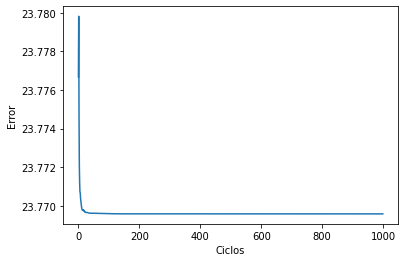

Error: 23.76957893371582
Tiempo de entrenamiento: 5.1985085010528564


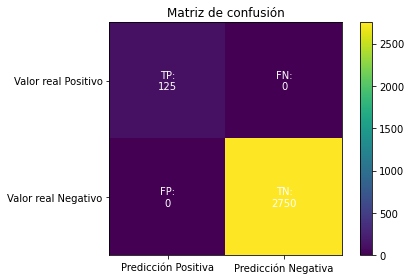

Accuracy: 100.00%


In [36]:
# Backpropagation -- ENTRENAMIENTO
model = Red(304,300,300,23)
params = model.parameters()
#optimizer = optim.SGD(params, lr=0.001, momentum=0, dampening=0, weight_decay=0, nesterov=False)
#optimizer = optim.Adam(params,lr=0.001,betas=(0.9,0.999),eps=1e-8,weight_decay=0,amsgrad=False)
optimizer = optim.Adagrad(params, lr=0.01,lr_decay=0,weight_decay=0,initial_accumulator_value=0,eps=1e-10)
tic = time()
model.training_(X_train,Y_train,optimizer,ciclos=1000)
toc = time()
print(f"Tiempo de entrenamiento: {toc-tic}")
# print(f"Tamaño del dataset: {len(df_ohe)}")
confusion(model,X_train,Y_train)
# Obtenemos el accuracy
totales = Y_train.size(0)
H = model.forward(X_train)
Y,_ = only_max(Y_train)
H,_ = only_max(H)
acertados = sum([h==y for h,y in zip(H,Y)]).item()
accuracy = acertados/totales 
print('Accuracy: {:.2f}%'.format(accuracy*100))

# Validación

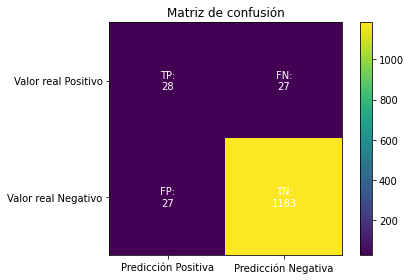

Accuracy: 22.40%


In [37]:
# Backpropagation -- VALIDACION
model.forward(X_val)
confusion(model,X_val,Y_val)
# Obtenemos el accuracy
totales = Y_train.size(0)
H = model.forward(X_val)
Y,_ = only_max(Y_val)
H,_ = only_max(H)
acertados = sum([h==y for h,y in zip(H,Y)]).item()
accuracy = acertados/totales 
print('Accuracy: {:.2f}%'.format(accuracy*100))